# LSTM-Based Time Series Anomaly Detection on NAB Dataset

In the exploration of the time-series anomaly detection using the NAB dataset, I could not get very good results using classical models (rolling z-score, stl residuals), for that analysis see the notebook entitled "NAB_Time_Series_Anomaly_Detection". The classical models could not learn the temporal context, capture the non-linear dynamics, or generalize across different anomaly types in a flexible way, so I've decided to level up to a deep-learning LSTM-based model. 

Long Short-Term Memory (LSTM) based approaches use a recurrent neural network to model sequences and retain memory over long time intervals. The goal of this approach is to learn a pattern over the recent past to predict the next value and flag anomalies when the predicted value deviates too much from the expected pattern. In effect, it employs a sequence-to-one prediction model. LSTM models are best used when the data has temporal dependencies, delayed effects, non-linear patterns, and/or unknown structure. 

Let's jump in and see if we can improve on our results from the classical models - where the best F1 score we could muster was ~.49. 

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import precision_recall_fscore_support

sns.set_theme(style = 'darkgrid', palette = 'mako')

## Load and normalize the data

In [2]:
file_path = 'data/realKnownCause/machine_temperature_system_failure.csv'
df = pd.read_csv(os.path.expanduser(file_path))
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace = True)

scaler = MinMaxScaler()
df['values_scaled'] = scaler.fit_transform(df[['value']])

## Define the lookback supervised learning format

In [27]:
def create_sequences(values, lookback):
    X, y = [], []
    for i in range(len(values) - lookback):
        X.append(values[i:i + lookback])
        y.append(values[i + lookback])
    return np.array(X), np.array(y)

lookback = 100
X, y = create_sequences(df['values_scaled'].values, lookback)
X = X.reshape((X.shape[0], X.shape[1], 1)) # because LSTM expects 3D input

## Train LSTM Model

In [28]:
model = Sequential()
model.add(LSTM(50, input_shape = (lookback, 1)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(X, y, epochs = 10, batch_size = 64, verbose = 1)

Epoch 1/10
354/354 [==============================] - 52s 136ms/step - loss: 0.0038
Epoch 2/10
354/354 [==============================] - 41s 115ms/step - loss: 2.9608e-04
Epoch 3/10
354/354 [==============================] - 28s 78ms/step - loss: 2.4150e-04
Epoch 4/10
354/354 [==============================] - 30s 84ms/step - loss: 2.1006e-04
Epoch 5/10
354/354 [==============================] - 49s 138ms/step - loss: 1.9511e-04
Epoch 6/10
354/354 [==============================] - 48s 137ms/step - loss: 1.7516e-04
Epoch 7/10
354/354 [==============================] - 43s 122ms/step - loss: 1.6595e-04
Epoch 8/10
354/354 [==============================] - 40s 112ms/step - loss: 1.5315e-04
Epoch 9/10
354/354 [==============================] - 37s 105ms/step - loss: 1.4730e-04
Epoch 10/10
354/354 [==============================] - 37s 105ms/step - loss: 1.4496e-04


In [29]:
# Make predictions
y_pred = model.predict(X)
errors = np.abs(y_pred.flatten() - y)

707/707 [==============================] - 31s 43ms/step


In [30]:
# Use a threshold to predict anomalies
threshold = np.percentile(errors, 95)
anomalies = errors > threshold

In [31]:
# map predictions back to the original index
results_df = df.iloc[lookback:].copy()
results_df['reconstruction_error'] = errors
results_df['lstm_anomaly'] = anomalies

## Compare modeled anomalies to true anomalies in dataset

In [32]:
label_file = 'labels/combined_windows.json'
with open(os.path.expanduser(label_file), 'r') as f:
    anomaly_windows = json.load(f)

dataset_key = 'realKnownCause/machine_temperature_system_failure.csv'
anomaly_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in anomaly_windows.get(dataset_key, [])]

def is_in_anomaly_window(timestamp, windows):
    return any(start <= timestamp <= end for start, end in windows)

results_df['true_anomaly'] = results_df.index.to_series().apply(lambda x: is_in_anomaly_window(x, anomaly_periods))

## Evaluate

In [33]:
precision, recall, f1, _ = precision_recall_fscore_support(
    results_df['true_anomaly'], results_df['lstm_anomaly'], average = 'binary')
print(f"LSTM Prediction Model - Precision: {precision: .2f}, Recall: {recall: .2f}, F1 Score: {f1: .2f}")

LSTM Prediction Model - Precision:  0.16, Recall:  0.08, F1 Score:  0.11


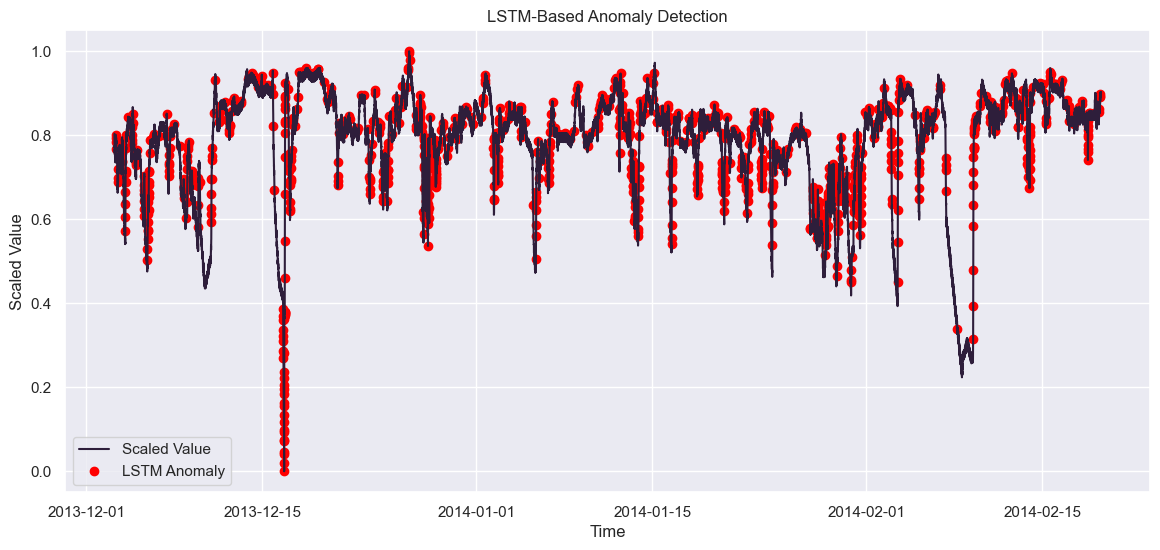

In [34]:
plt.figure(figsize=(14,6))
plt.plot(results_df.index, results_df['values_scaled'], label='Scaled Value')
plt.scatter(results_df.index[results_df['lstm_anomaly']], 
            results_df['values_scaled'][results_df['lstm_anomaly']], 
            color='red', label='LSTM Anomaly')
plt.title('LSTM-Based Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.show()